In [1]:
import uuid
from langgraph.store.memory import InMemoryStore

In [2]:
in_memory_store = InMemoryStore()

In [3]:
user_id = "1"
namespace_for_memory = (user_id, "memories")

key = str(uuid.uuid4())

value = {"food_preference": "I like pizza"}

in_memory_store.put(namespace_for_memory, key, value)

In [6]:
memory = in_memory_store.get(namespace_for_memory, key)
memory.dict()

{'value': {'food_preference': 'I like pizza'},
 'key': 'cde4a32e-179f-4552-8e0a-bab96f5e4cb9',
 'namespace': ['1', 'memories'],
 'created_at': '2025-01-01T18:06:28.514733+00:00',
 'updated_at': '2025-01-01T18:06:28.514735+00:00'}

# long-term memory

In [8]:
from langchain_openai import ChatOpenAI
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig


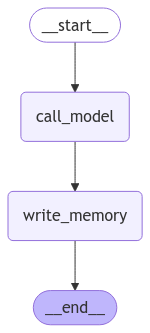

In [9]:
model = ChatOpenAI(model="gpt-4o", temperature=0)

MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user.
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

CREATE_MEMORY_INSTRUCTION = """You are collecting information about the user to personalize your responses.

CURRENT USER INFORMATION:
{memory}

INSTRUCTIONS:
1. Review the chat history below carefully
2. Identify new information about the user, such as:
    - Personal details (name, location)
    - Preferences (likes, dislikes)
    - Interests and hobbies
    - Past experiences
    - Goals or future plans
3. Merge any new information with existing memory
4. Format the memory as a clear, bulleted list
5. If new information conflicts with existing memory, keep the most recent version

Remember: Only include factual information directly stated by the user. Do not make assumptions or inferences.

Based on the chat history below, please update the user information:"""

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Load memory from the store and use it to personalize the chatbot's response"""

    user_id = config["configurable"]["user_id"]

    namespace = ("memory", user_id)
    key = "user_memory"
    existing_memory = store.get(namespace, key)

    if existing_memory:
        existing_memory_content = existing_memory.value.get('memory')
    else:
        existing_memory_content = "No existing memory found."

    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=existing_memory_content)
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Reflect on the chat history and save a memory to the store"""

    user_id = config["configurable"]["user_id"]

    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    if existing_memory:
        existing_memory_content = existing_memory.value.get('memory')
    else:
        existing_memory_content = "No existing memory found."

    system_msg = CREATE_MEMORY_INSTRUCTION.format(memory=existing_memory_content)
    new_memory = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    key = "user_memory"

    store.put(namespace, key, {"memory": new_memory.content})

builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

across_thread_memory = InMemoryStore()
within_thread_memory = MemorySaver()

graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

input_messages = [HumanMessage(content="I like to walk around down-town Chicago")]

for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to walk around down-town Chicago
================================== Ai Message ==================================

That sounds like a great way to explore the city, Dave! Downtown Chicago has so much to offer, from the architecture to the vibrant atmosphere. Do you have any favorite spots or activities you enjoy while you're there?


In [17]:
thread = {"configurable": {"thread_id": "1"}}
state = graph.get_state(thread).values
for m in state["messages"]: 
    m.pretty_print()

================================ Human Message =================================

Hi, my name is Lance
================================== Ai Message ==================================

Hello, Lance! It's nice to meet you. How can I assist you today?
================================ Human Message =================================

Hi, my name is Lance
================================== Ai Message ==================================

Hello again, Lance! How can I help you today?
================================ Human Message =================================

Hi, my name is Dave
================================== Ai Message ==================================

Hello, Dave! It's nice to meet you. How can I assist you today?
================================ Human Message =================================

I like to walk around down-town Chicago
================================== Ai Message ==================================

That sounds like a great way to explore the city, Dave! Downtown Ch

In [18]:
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.dict()

{'value': {'memory': "- User's name is Dave.\n- Dave likes to walk around downtown Chicago."},
 'key': 'user_memory',
 'namespace': ['memory', '1'],
 'created_at': '2025-01-01T19:05:39.870870+00:00',
 'updated_at': '2025-01-01T19:05:39.870871+00:00'}

In [19]:
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

input_messages = [HumanMessage(content="Hi! Where would you recommend that I do hiking?")]

for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi! Where would you recommend that I do hiking?
================================== Ai Message ==================================

Hi Dave! Since you enjoy walking around downtown Chicago, you might appreciate some nearby hiking spots that offer a change of scenery. Here are a few recommendations:

1. **Starved Rock State Park**: Located about 90 miles southwest of Chicago, this park offers beautiful canyons, waterfalls, and scenic overlooks. It's a great place for a day trip.

2. **Matthiessen State Park**: Close to Starved Rock, Matthiessen offers similar geological features with less crowd. It's perfect for exploring canyons and streams.

3. **Indiana Dunes National Park**: Just an hour's drive from Chicago, this park offers diverse trails through dunes, wetlands, and forests, with beautiful views of Lake Michigan.

4. **Waterfall Glen Forest Preserve**: Located in DuPage County, this preserve has a var

In [ ]:
input_messages = [HumanMessage(content="Great, are there any notable places that I should check out as well?")]

for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()